# SVM con Kernel Personalizzato

Questo notebook dimostra come creare e utilizzare un kernel personalizzato per SVM che gestisce sia feature numeriche che categoriche.

## Import delle librerie necessarie

In [13]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

np.random.seed(42)

## PARTE 1: Generazione del Dataset

Generiamo un dataset di prodotti con:
- **Features numeriche**: prezzo e rating
- **Feature categorica**: categoria del prodotto (0, 1, 2)
- **Target**: successo del prodotto (binario)

Le regole per il successo variano per categoria:
- **Categoria 0**: successo se prezzo basso e rating alto
- **Categoria 1**: successo se prezzo medio
- **Categoria 2**: successo se rating molto alto

In [24]:
def generate_product_dataset(n_samples=300):
    """
    Genera un dataset di prodotti con caratteristiche numeriche e categoriche.

    Features:
    - prezzo (numerico): prezzo del prodotto
    - rating (numerico): valutazione media
    - categoria (categorico): tipo di prodotto (0, 1, 2)

    Target:
    - successo (binario): 1 se il prodotto ha successo, 0 altrimenti
    """

    # Caratteristiche numeriche
    prezzo = np.random.uniform(10, 100, n_samples)
    rating = np.random.uniform(1, 5, n_samples)

    # Caratteristica categorica (3 categorie)
    categoria = np.random.choice([0, 1, 2], n_samples)

    successo = np.zeros(n_samples)
    for i in range(n_samples):
        if categoria[i] == 0:
            successo[i] = 1 if (prezzo[i] < 40 and rating[i] > 3.5) else 0
        elif categoria[i] == 1:
            successo[i] = 1 if (30 < prezzo[i] < 70) else 0
        else:  # categoria == 2
            successo[i] = 1 if (rating[i] > 4.0) else 0

    # Aggiungi un po' di rumore
    noise_idx = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
    successo[noise_idx] = 1 - successo[noise_idx]

    # Crea il DataFrame
    df = pd.DataFrame({
        'prezzo': prezzo,
        'rating': rating,
        'categoria': categoria,
        'successo': successo.astype(int)
    })

    return df

## PARTE 2: Definizione dei Kernel

Implementiamo tre tipi di kernel:

1. **RBF Kernel** per le features numeriche
2. **Categorical Kernel (Delta Kernel)** per le features categoriche
3. **Composite Kernel** che combina i due precedenti

In [25]:
def rbf_kernel_numeric(X1, X2, gamma=1.0):
    """
    Kernel RBF (Radial Basis Function) per features numeriche.

    K(x, y) = exp(-gamma * ||x - y||^2)

    Args:
        X1: array di shape (n_samples_1, n_features)
        X2: array di shape (n_samples_2, n_features)
        gamma: parametro del kernel

    Returns:
        Matrice kernel di shape (n_samples_1, n_samples_2)
    """
    return rbf_kernel(X1,X2,gamma=gamma)


def categorical_kernel(X1, X2):
    """
    Kernel per features categoriche (delta kernel).

    K(x, y) = 1 se x == y, 0 altrimenti

    Args:
        X1: array di shape (n_samples_1,)
        X2: array di shape (n_samples_2,)

    Returns:
        Matrice kernel di shape (n_samples_1, n_samples_2)
    """

    # Suggerimento: utilizza broadcasting per confrontare gli elementi
    # e restituire una matrice di 0 e 1
    return (X1[:, None] == X2[None, :]).astype(float)


def composite_kernel(X1, X2, gamma=1.0):
    """
    Kernel composito: prodotto del kernel RBF (per features numeriche)
    e kernel categorico.

    K((x_num, x_cat), (y_num, y_cat)) = K_RBF(x_num, y_num) * K_cat(x_cat, y_cat)

    Args:
        X1: array di shape (n_samples_1, 3) [prezzo, rating, categoria]
        X2: array di shape (n_samples_2, 3) [prezzo, rating, categoria]
        gamma: parametro per il kernel RBF

    Returns:
        Matrice kernel di shape (n_samples_1, n_samples_2)
    """
    # Separa features numeriche e categoriche
    X1_num = X1[:, :2]
    X2_num = X2[:, :2]
    X1_cat = X1[:, 2]
    X2_cat = X2[:, 2]

    # Calcola i kernel separatamente
    K_num = rbf_kernel_numeric(X1_num, X2_num, gamma=gamma)
    K_cat = categorical_kernel(X1_cat, X2_cat)

    # Restituisci il prodotto elemento per elemento
    return K_num * K_cat

def composite_kernel2(X1, X2, gamma=1.0):
  return rbf_kernel(X1, X2, gamma=gamma)


## Funzione di Visualizzazione

Visualizza i dati separati per categoria, mostrando training e test set.

In [26]:
def visualize_results(X_train, y_train, X_test, y_test):
    """
    Visualizza i dati colorati per categoria.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    categories = [0, 1, 2]
    colors = ['red', 'blue']

    for idx, cat in enumerate(categories):
        ax = axes[idx]

        # Filtra per categoria
        mask_train = X_train[:, 2] == cat
        mask_test = X_test[:, 2] == cat

        # Plot training data
        for label in [0, 1]:
            mask = (y_train == label) & mask_train
            ax.scatter(X_train[mask, 0], X_train[mask, 1],
                      c=colors[label], marker='o', alpha=0.6,
                      label=f'Train - Classe {label}')

        # Plot test data
        for label in [0, 1]:
            mask = (y_test == label) & mask_test
            ax.scatter(X_test[mask, 0], X_test[mask, 1],
                      c=colors[label], marker='x', s=100, alpha=0.8,
                      label=f'Test - Classe {label}')

        ax.set_xlabel('Prezzo')
        ax.set_ylabel('Rating')
        ax.set_title(f'Categoria {cat}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('svm_custom_kernel_visualization.png', dpi=150)
    print("\nGrafico salvato come 'svm_custom_kernel_visualization.png'")

## PARTE 3: Addestramento e Valutazione

### Generazione del dataset

In [27]:
df = generate_product_dataset(n_samples=300)

print("Dataset generato:")
print(df.head(10))
print(f"\nDistribuzione classi:\n{df['successo'].value_counts()}")

Dataset generato:
      prezzo    rating  categoria  successo
0  68.199843  2.937594          1         1
1  72.385769  3.643280          1         0
2  14.643623  3.212006          2         0
3  70.292572  3.389903          1         0
4  13.974889  4.135330          0         1
5  62.943738  2.923615          1         1
6  99.941815  1.163016          2         0
7  60.022592  1.655998          1         0
8  52.588911  2.754429          1         1
9  38.156937  3.899306          1         1

Distribuzione classi:
successo
0    205
1     95
Name: count, dtype: int64


### Preparazione dei dati e split train/test

In [28]:
X = df[['prezzo', 'rating', 'categoria']].values
y = df['successo'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Addestramento SVM con kernel personalizzato

Creiamo una funzione kernel lambda che utilizza il nostro `composite_kernel` e addestriamo l'SVM.

In [30]:
kernel_func = lambda X1, X2: composite_kernel(X1, X2, gamma=0.1)

svm = SVC(kernel=kernel_func)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")


Accuracy: 0.744


### Report di classificazione dettagliato

In [20]:
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        64
           1       0.70      0.54      0.61        26

    accuracy                           0.80        90
   macro avg       0.76      0.72      0.74        90
weighted avg       0.79      0.80      0.79        90



### Visualizzazione dei risultati

Visualizziamo i dati per ciascuna categoria, mostrando la distribuzione di training e test set.


Grafico salvato come 'svm_custom_kernel_visualization.png'


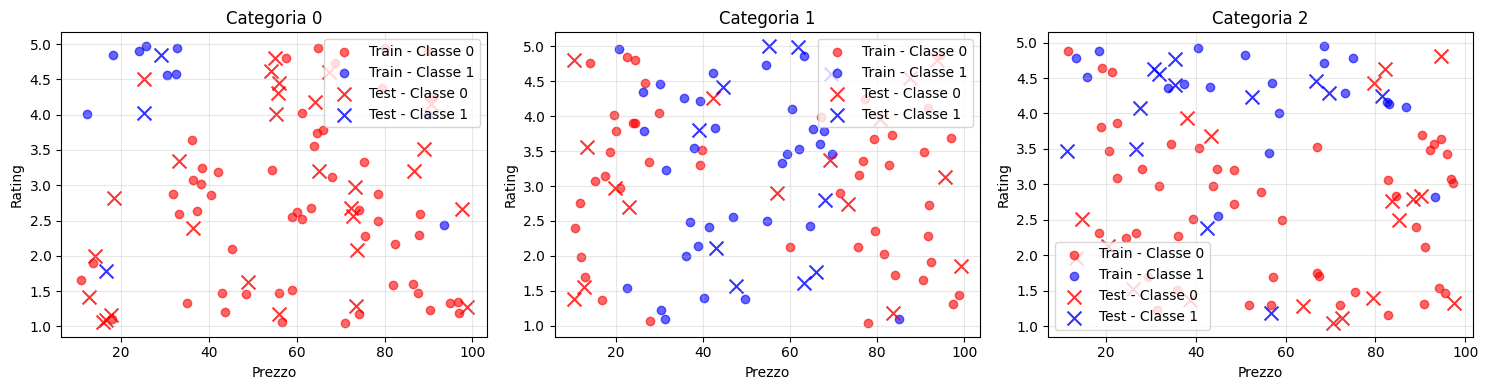

In [21]:
visualize_results(X_train, y_train, X_test, y_test)